In [1]:
#pip install statsmodels

In [2]:
#pip install pmdarima

In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None #remove warning masseges from panda
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller #stationary test
from statsmodels.tsa.arima.model import ARIMA 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from pmdarima.arima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats


In [4]:
POS = pd.read_csv('C:/Users/althy/Desktop/Graduation_Project/Final_Graduation_Project-main/POS_monthly_2023.csv',index_col='Date', parse_dates=True)

In [5]:
POS = pd.DataFrame(POS)

<h4> Exploring and cleaning Data

In [6]:
POS.head(5)

,Total
Date,
Jan-15,32156481.0
Feb-15,29603197.0
Mar-15,32793427.0
Apr-15,30356911.0
May-15,33099974.0


In [7]:
POS.describe()

,Total
count,9.700000e+01
mean,2.088249e+08
std,2.062546e+08
min,2.960320e+07
25%,5.215320e+07
50%,1.063572e+08
75%,3.465955e+08
max,6.919239e+08


In [8]:
#checking for Nan values
POS.isna().values.any()

True

In [9]:
POS[POS.index.isna()]

,Total
Date,


seeing the NaN rows we can conclude that they are a mistake, so we can remove them

In [10]:
clean_POS = POS.dropna()

In [11]:
#checking for duplicated in date column.
clean_POS.index.duplicated().any()

False

C:\Users\althy\AppData\Local\Temp\ipykernel_2408\3657154870.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.lineplot(x="Date", y="Total",


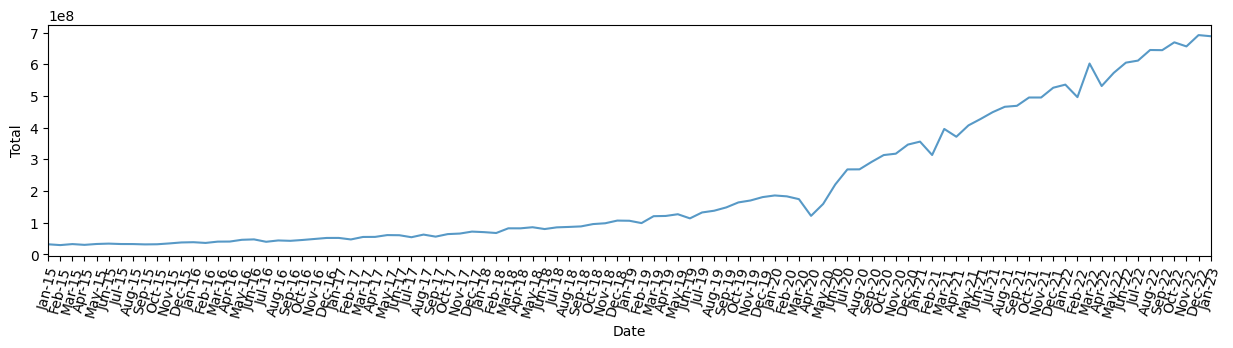

In [53]:
#making line plot 
plt.xticks(rotation=75)
fig = plt.gcf()
fig.set_size_inches(15, 3)
scatter = sns.lineplot(x="Date", y="Total", 
                          sizes=(40, 800), alpha=0.75, palette="BrBG", legend=False,
                          data=clean_POS)
plt.xlim((clean_POS.index[0], clean_POS.index[-1]))
plt.show()

Testing seasonality

<h3> Testing stationary

In [55]:
#function to test statonarity using Dickey-fuller test and ploting it 
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=6).mean()
    movingSTD = timeseries.rolling(window=6).std()
  
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries.values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    #Plot rolling statistics
    fig = plt.gcf()
    fig.set_size_inches(15, 3)
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.xticks(rotation=75)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlim((timeseries.index[0], timeseries.index[-1]))
    plt.show(block=False)

Results of Dickey Fuller Test:
Test Statistic                 -0.420112
p-value                         0.906686
#Lags Used                     12.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


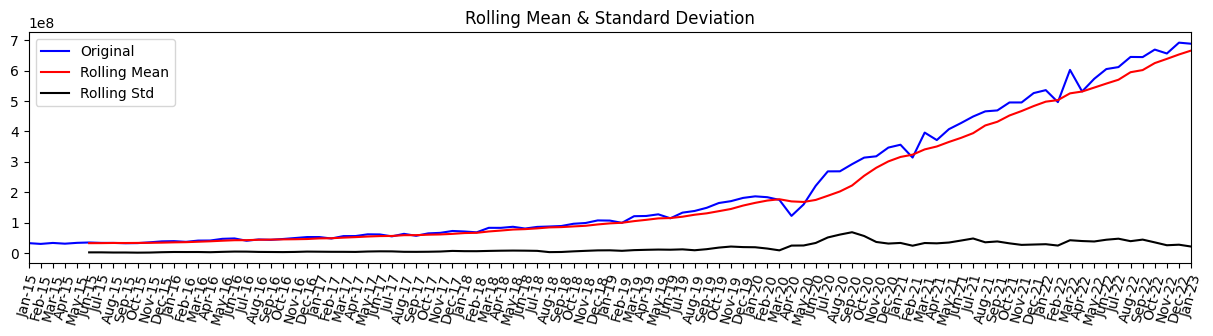

In [56]:
test_stationarity(clean_POS)

<h4> since p-value > 0.05 it's not stationary
so we will try transforming it with taking the first difference

Results of Dickey Fuller Test:
Test Statistic                 -1.188642
p-value                         0.678463
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


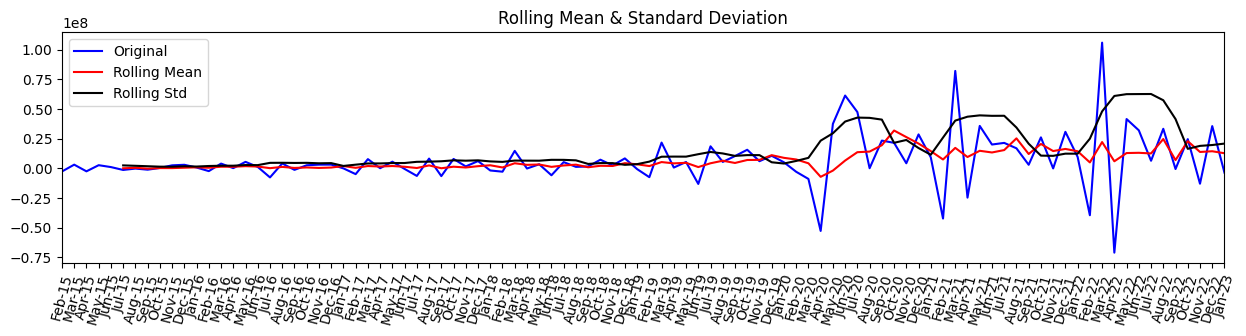

In [57]:
test_stationarity(clean_POS.diff().dropna())

<h5> p-value still high, so we will transform the data again by taking the log <h5>

Results of Dickey Fuller Test:
Test Statistic                 -5.104558
p-value                         0.000014
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


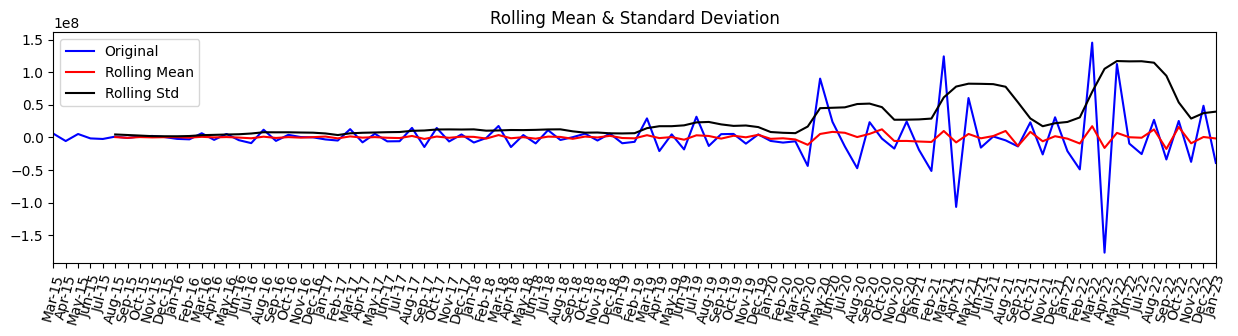

In [58]:
test_stationarity(clean_POS.diff().diff().dropna())

<h4> since the data got stationary after the seconed diffrence, then the d in ARIMA(p,d,q) is equal to 2

In [59]:
#function to analyze residual
def residual_analysis(residual):
    alpha = 0.05
 
    #testing H0: E(res)=0, if p-value < 0.05 then reject H0
    Eres = stats.ttest_1samp(residual, 0).pvalue
    print("checking if residuals are zero mean")
    print("h0: residuals are zero mean, h1: residuals are not zero mean")
    if Eres < alpha:
        print(f"since p-value {round(Eres,4)} < alpha = {alpha} we reject null hypothesis, residuals are not zero mean. \n")
    else:
        print(f"since p-value {round(Eres,4)} > alpha = {alpha} we accept null hypothesis, residuals are zero mean. \n")

    #testing the normality of the residuals, H0: residuals are normally distributed
    #using the Anderson-Darling test, if p-value < 0.05 then reject H0
    der_test = stats.anderson(residual).critical_values[2]
    print(f"Anderson-Darling test statistic for checking normality")
    print("h0: residuals are normally distributed, h1: residuals are not normally distributed")
    if der_test < alpha:
        print(f"since p-value {round(der_test,4)} < alpha = {alpha} we reject null hypothesis, residuals are not normally distributed. \n")
    else:
        print(f"since p-value {round(der_test,4)} > alpha = {alpha} we accept null hypothesis, residuals are normally distributed. \n")

    #checking for correlation between residuals
    result = acorr_ljungbox(residual)
    print("checking for correlation between residuals")
    print("h0: residuals are uncorrelated, h1: residuals are correlated")
    if any(result.lb_pvalue < alpha):
        print(f"since all p-value < alpha = {alpha} we reject null hypothesis, residuals are correlated. \n")
    else:
        print(f"since all p-value > alpha = {alpha} we accept null hypothesis, residuals are uncorrelated. \n")

    #If the residuals are randomly distributed around zero,
    #we would expect to see a roughly symmetric distribution centered around zero with no significant skewness or kurtosis.

    print("checking for randomnis of residuals")
    print("if the residuals are random then we would see a symmetric distribution centered around zero with no significant skewness or kurtosis")
    sns.set_style('whitegrid')
    plt.figure(figsize=(4, 3))
    sns.kdeplot(residual, fill=True)
    plt.axvline(x=0, color='k', linestyle='-')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.title('Density Plot of Residuals, for testing random distribution')
    plt.show()
    

In [18]:
#function to compare models using AIC and BIC scores
def assess_arima(model):
    AIC = model.aic
    BIC = model.bic
    KPI = {
        'AIC':AIC,
        'BIC':BIC,
        }   
    for key in KPI:
        print(key, '=', KPI[key])

In [19]:
#function that calculate mae, mape, mse and rmse between test data and predicted data
def KPI(test_data,y_pred):
    mae = mean_absolute_error(y_true=test_data, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=test_data, y_pred=y_pred)
    mse = mean_squared_error(y_true=test_data, y_pred=y_pred)
    rmse = np.sqrt(mse)
    #corr = np.corrcoef(y_pred.Total, test_data.Total)
    KPI = {
        'mape':mape,
        'mae':mae,
        'mse':mse,
        'rmse':rmse,
        #'corr':corr
    }   
    for key in KPI:
        print(key, '=', KPI[key])

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


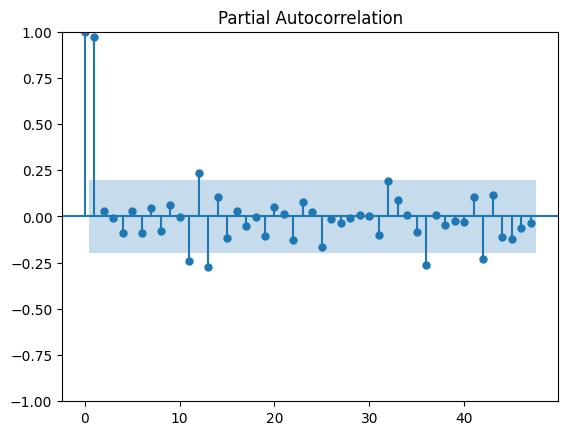

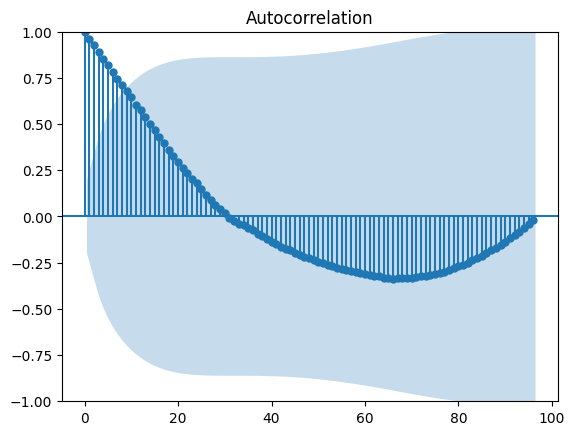

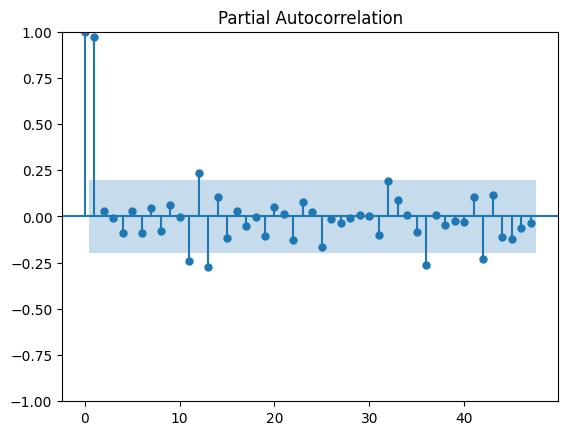

In [20]:
# Assuming 'clean_POS' is a pandas Series containing your time series data
max_lag = len(clean_POS) - 1

# Plot ACF with all lags
plot_acf(clean_POS, lags=max_lag)

# Plot PACF with all lags
plot_pacf(clean_POS, lags=47)
#plot_acf(clean_POS)
#plot_pacf(clean_POS)

<h3> since autocorrelation decay to zero, and partial autocorrelation cuts off after the 2nd itme lag, the model is ARIMA(0,2,2)

In [21]:
model = ARIMA(clean_POS, order=(0,2,2)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   97
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -1735.947
Date:                Sun, 25 Jun 2023   AIC                           3477.893
Time:                        17:33:47   BIC                           3485.555
Sample:                             0   HQIC                          3480.989
                                 - 97                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4228      0.087    -16.387      0.000      -1.593      -1.253
ma.L2          0.4819      0.077      6.288      0.000       0.332       0.632
sigma2      6.206e+14        nan        nan        n

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [22]:
scipy.stats.shapiro(model.resid)

ShapiroResult(statistic=0.8437144160270691, pvalue=1.0246549386749848e-08)

checking if residuals are zero mean
h0: residuals are zero mean, h1: residuals are not zero mean
since p-value 0.4551 > alpha = 0.05 we accept null hypothesis, residuals are zero mean. 

Anderson-Darling test statistic for checking normality
h0: residuals are normally distributed, h1: residuals are not normally distributed
since p-value 0.758 > alpha = 0.05 we accept null hypothesis, residuals are normally distributed. 

checking for correlation between residuals
h0: residuals are uncorrelated, h1: residuals are correlated
since all p-value > alpha = 0.05 we accept null hypothesis, residuals are uncorrelated. 

checking for randomnis of residuals
if the residuals are random then we would see a symmetric distribution centered around zero with no significant skewness or kurtosis


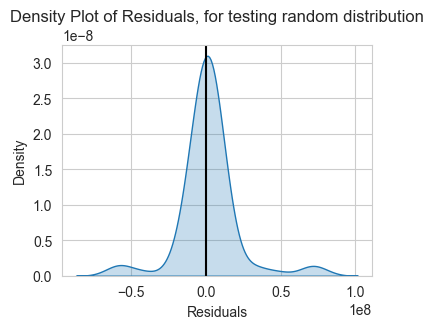

In [60]:
residual_analysis(model.resid)

<h5> since this model passed the raisdual analysis we will procced with prediciton

<h4> To make sure we have the best model, we will try finding another model and compare it with ARIMA(0,2,2)

In [24]:
model2 = ARIMA(clean_POS, order=(2,2,0)).fit()
print(model2.summary())
model2.pvalues


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   97
Model:                 ARIMA(2, 2, 0)   Log Likelihood               -1742.634
Date:                Sun, 25 Jun 2023   AIC                           3491.268
Time:                        17:33:47   BIC                           3498.930
Sample:                             0   HQIC                          3494.364
                                 - 97                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0837      0.043    -25.027      0.000      -1.169      -0.999
ar.L2         -0.5118      0.060     -8.590      0.000      -0.629      -0.395
sigma2      5.068e+14   3.26e-17   1.56e+31      0.0

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ar.L1     3.099399e-138
ar.L2      8.689503e-18
sigma2     0.000000e+00
dtype: float64

<h5> since p>|z| < .05, we accept this model <h5>

In [25]:
residual_analysis(model2.resid)

checking if residuals are zero mean
h0: residuals are zero mean, h1: residuals are not zero mean
since p-value 0.9401 > alpha = 0.05 we accept null hypothesis, residuals are zero mean. 

Anderson-Darling test statistic for checking normality
h0: residuals are normally distributed, h1: residuals are not normally distributed
since p-value 0.758 > alpha = 0.05 we accept null hypothesis, residuals are normally distributed. 

checking for correlation between residuals
h0: residuals are uncorrelated, h1: residuals are correlated
since all p-value < alpha = 0.05 we reject null hypothesis, residuals are correlated. 



<h5> since this model failed residual anaylsis -there is correlation between residuals- we will try find another

<h5> let's check ARIMA(1,2,1) and see if we can use it too

In [26]:
model3 = ARIMA(clean_POS, order=(1,2,1)).fit()
print(model3.summary())
model3.pvalues

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   97
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1733.428
Date:                Sun, 25 Jun 2023   AIC                           3472.856
Time:                        17:33:47   BIC                           3480.518
Sample:                             0   HQIC                          3475.952
                                 - 97                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4832      0.066     -7.376      0.000      -0.612      -0.355
ma.L1         -0.9179      0.054    -17.116      0.000      -1.023      -0.813
sigma2      5.353e+14        nan        nan        n

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ar.L1     1.633840e-13
ma.L1     1.118201e-65
sigma2             NaN
dtype: float64

In [27]:
residual_analysis(model3.resid)

checking if residuals are zero mean
h0: residuals are zero mean, h1: residuals are not zero mean
since p-value 0.4551 > alpha = 0.05 we accept null hypothesis, residuals are zero mean. 

Anderson-Darling test statistic for checking normality
h0: residuals are normally distributed, h1: residuals are not normally distributed
since p-value 0.758 > alpha = 0.05 we accept null hypothesis, residuals are normally distributed. 

checking for correlation between residuals
h0: residuals are uncorrelated, h1: residuals are correlated
since all p-value > alpha = 0.05 we accept null hypothesis, residuals are uncorrelated. 



<h5> this model passed the residual analysis so we will compare it to the original<h5>

In [28]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                   97
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -1735.947
Date:                Sun, 25 Jun 2023   AIC                           3477.893
Time:                        17:33:47   BIC                           3485.555
Sample:                             0   HQIC                          3480.989
                                 - 97                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4228      0.087    -16.387      0.000      -1.593      -1.253
ma.L2          0.4819      0.077      6.288      0.000       0.332       0.632
sigma2      6.206e+14        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                98.71
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):              29.16   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.21e+48. Standard errors may be unstable.
"""

In [29]:
print("we will compare the first model ARIMA(0,2,2) with the second model ARIMA(1,2,1) since they passed residual analysis")
print("\nthe scores of the first model are:")
assess_arima(model)
print("\nthe scores of the second model are:")
assess_arima(model3)

we will compare the first model ARIMA(0,2,2) with the second model ARIMA(1,2,1) since they passed residual analysis

the scores of the first model are:
AIC = 3477.8930164967137
BIC = 3485.554647171515

the scores of the second model are:
AIC = 3472.855989668543
BIC = 3480.5176203433443


<h5> since the second model has lower AIC and BIC scores we will use it for our prediction

In [30]:
split_index = int(0.80 * len(clean_POS))
train_data = clean_POS.iloc[:split_index, :]
test_data = clean_POS.iloc[split_index:, :]


In [ ]:
model = ARIMA(train_data, order=(1,2,1)).fit()
y_pred = pd.DataFrame(index= test_data.index)
y_pred['Total'] = model.forecast(len(test_data)).values

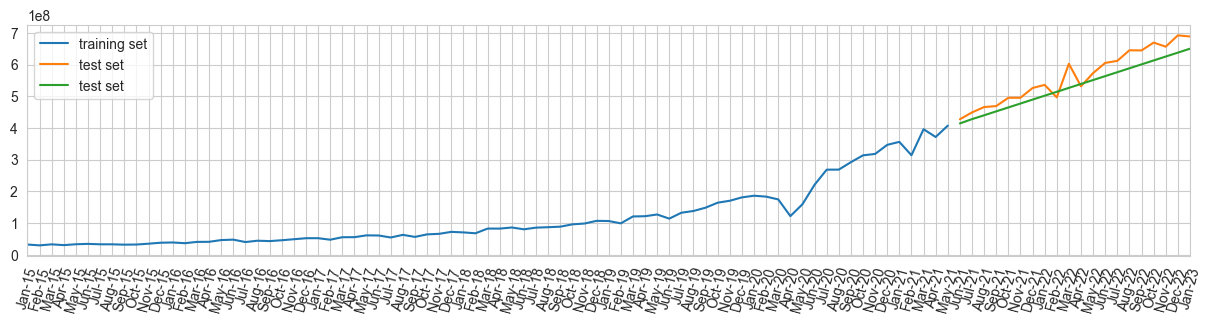

In [61]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 3)
plt.plot(train_data.dropna(), label = 'training set')
plt.plot(test_data.dropna(), label='test set')
plt.plot(y_pred, label='test set')
plt.xlim((clean_POS.index[0], test_data.index[-1]))
plt.xticks(rotation=75)
plt.legend()
plt.show() 

In [33]:
KPI(test_data=test_data,y_pred=y_pred)

mape = 0.05823304196724288
mae = 33896746.46224184
mse = 1436188150580498.5
rmse = 37897073.11363898


In [34]:
date_index = pd.date_range(start='2023-01',end= '2023-07', freq='M')
date_index

DatetimeIndex(['2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
               '2023-05-31', '2023-06-30'],
              dtype='datetime64[ns]', freq='M')

In [35]:
model = ARIMA(clean_POS, order=(1,2,1)).fit()
forecast = model.forecast(len(date_index), alpha=0.05)
get_forecast = model.get_forecast(steps=len(date_index),dynamic=True)
confidence_intervals = get_forecast.conf_int()

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\althy\AppData\Local\Pro

In [36]:
forecast = pd.DataFrame(forecast.values, index=date_index, columns=['Values'])
CI = pd.DataFrame(confidence_intervals.values, index=date_index,columns=['lower_CI', 'Upper_CI'])
forecast.index = forecast.index.strftime("%b-%y")
CI.index = CI.index.strftime("%b-%y")
forecast_CI = pd.concat([forecast, CI], axis=1)
forecast_CI

,Values,lower_CI,Upper_CI
Jan-23,7.103366e+08,6.649888e+08,7.556843e+08
Feb-23,7.199726e+08,6.671143e+08,7.728310e+08
Mar-23,7.355674e+08,6.694799e+08,8.016550e+08
Apr-23,7.482832e+08,6.723739e+08,8.241924e+08
May-23,7.623899e+08,6.755446e+08,8.492352e+08
Jun-23,7.758246e+08,6.786628e+08,8.729864e+08


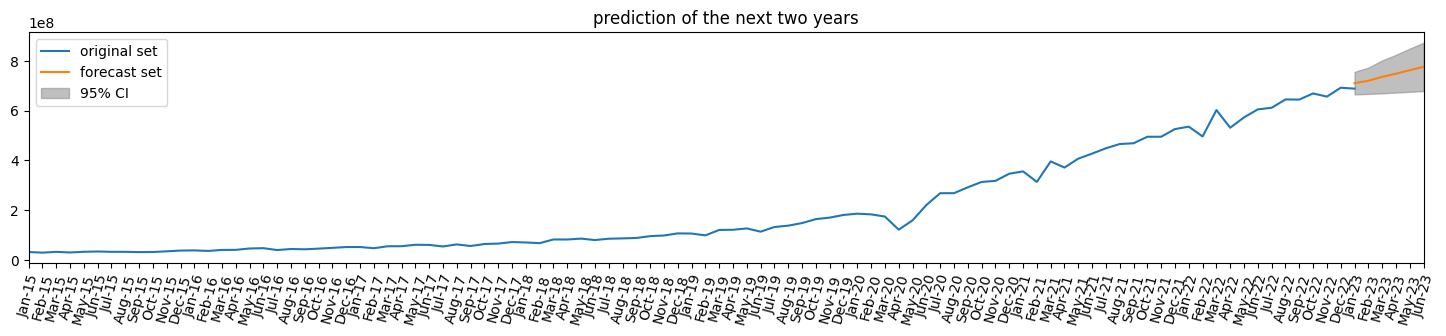

In [37]:
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.plot(clean_POS, label = 'original set')
plt.plot(forecast , label='forecast set')
plt.fill_between(forecast_CI.index, forecast_CI.lower_CI, forecast_CI.Upper_CI, alpha=0.5, color='gray', label='95% CI')
# Set x-axis limits to start from the first date in the data
plt.xlim((clean_POS.index[0], forecast_CI.index[-1]))
plt.xticks(rotation=75)
plt.xticks()
plt.legend()
plt.title('prediction of the next two years')
plt.show() 

<h3> Ponus, trying auto arima function


In [38]:
auto_model = auto_arima(clean_POS)
auto_y_pred = pd.DataFrame(index= date_index)
auto_y_pred['Total'] = auto_model.predict(len(date_index)).values


c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [39]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   97
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -1725.838
Date:                Sun, 25 Jun 2023   AIC                           3465.676
Time:                        17:33:50   BIC                           3483.553
Sample:                             0   HQIC                          3472.900
                                 - 97                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.2983      0.107    -21.394      0.000      -2.509      -2.088
ar.L2         -1.9140      0.145    -13.179      0.000      -2.199      -1.629
ar.L3         -0.5516      0.067     -8.203      0.000      -0.683      -0.420
ma.L1          0.9635      0.120      8.020      0.000       0.728       1.199
ma.L2         -0.7459      0.113     -6.590      0.000      -0.968      -0.524
ma.L3         -0.8740      0.123     -7.077      0.000      -1.116      -0.632
sigma2      3.997e+14   2.96e-16   1.35e+30      0.000       4e+14       4e+14
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               137.76
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):              23.97   Skew:                             0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.95e+45. Standard errors may be unstable.
"""

In [40]:
residual_analysis(auto_model.resid())

checking if residuals are zero mean
h0: residuals are zero mean, h1: residuals are not zero mean
since p-value 0.4996 > alpha = 0.05 we accept null hypothesis, residuals are zero mean. 

Anderson-Darling test statistic for checking normality
h0: residuals are normally distributed, h1: residuals are not normally distributed
since p-value 0.758 > alpha = 0.05 we accept null hypothesis, residuals are normally distributed. 

checking for correlation between residuals
h0: residuals are uncorrelated, h1: residuals are correlated
since all p-value > alpha = 0.05 we accept null hypothesis, residuals are uncorrelated. 



In [41]:
split_index = int(0.80 * len(clean_POS))
auto_train_data = clean_POS.iloc[:split_index, :]
auto_test_data = clean_POS.iloc[split_index:, :]

In [42]:
auto_model = auto_arima(auto_train_data)

In [43]:
auto_y_pred = pd.DataFrame(index= auto_test_data.index)
auto_y_pred['Total'] = auto_model.predict(len(auto_test_data)).values

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [44]:
KPI(y_pred=auto_y_pred, test_data=auto_test_data)

mape = 0.05206529737946378
mae = 30086577.166925192
mse = 1123490979632695.6
rmse = 33518516.96648728


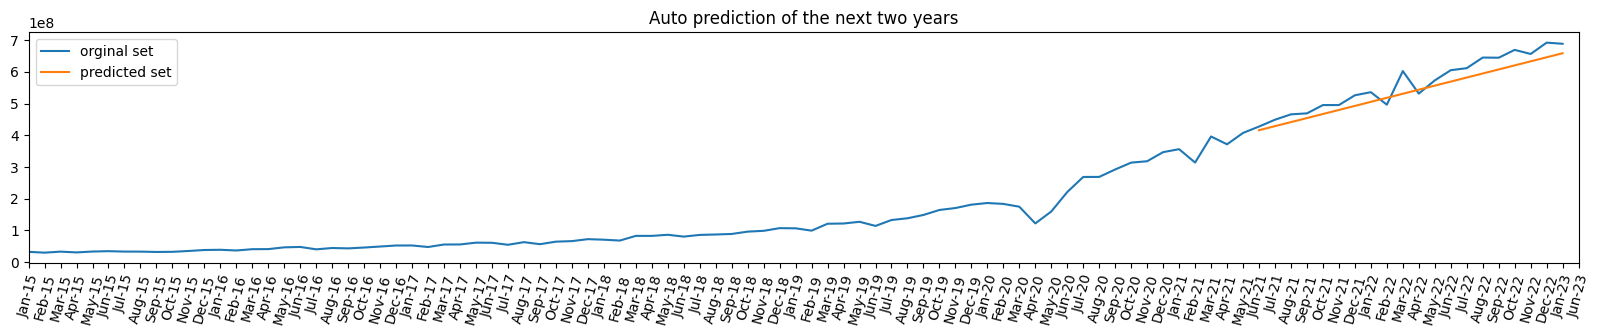

In [49]:
fig = plt.gcf()
fig.set_size_inches(20, 3)
plt.plot(clean_POS, label = 'orginal set', marker = '')
plt.plot(auto_y_pred.Total, label='predicted set')
plt.xlim((clean_POS.index[0], forecast_CI.index[-1]))
plt.xticks(rotation=75)
plt.title('Auto prediction of the next two years')
plt.legend()
plt.show() 

<h3> let's compare these two models, my model and the auto arima model

In [50]:
assess_arima(model)

AIC = 3472.855989668543
BIC = 3480.5176203433443


In [51]:
#finding AIC and BIC for auto_arima model
print('AIC =', auto_model.aic())
print('BIC =', auto_model.bic())

AIC = 2722.413031130542
BIC = 2729.365495471151
